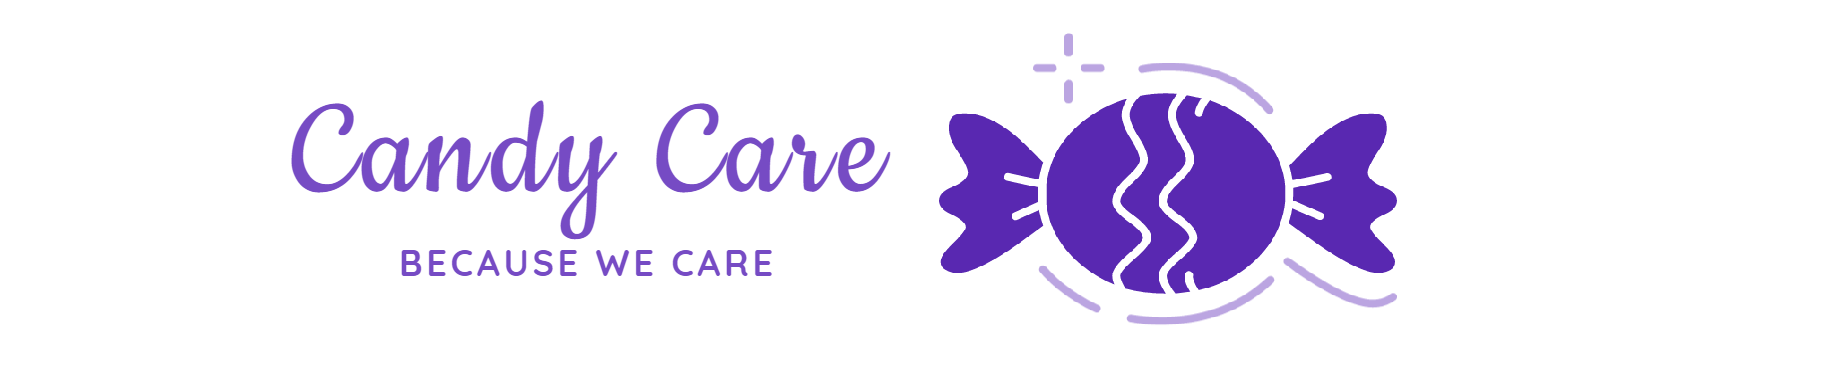

In [28]:
from IPython.display import Image
Image(filename='unknown.png') 

__PML WS 2021/22__ <br>
_by Julian Mierisch and Anna Martynova_

### Goals
1. Cluster Analysis
    - to understand how many groups there are in the data and their chrarcteristics
2. Prediction Models
    - one for sugarpercent
    - one for pricepercent
    - on for winpercent

### Import packages and data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns

from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [2]:
candyDataAll = pd.read_csv('candy-data.csv')
candyDataAll

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


## Data exploration 
### Inspect distribution of candy attributes in dataset

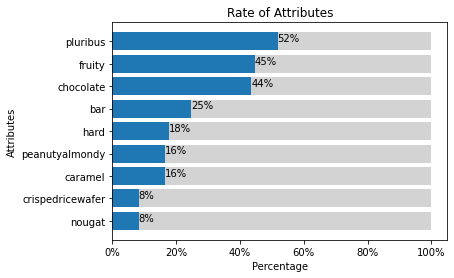

In [3]:
#Manipulate data to only get attributes
candyAttributes = candyDataAll.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
data = {'Attributes': candyAttributes.columns, 'Values': candyAttributes.sum()/len(candyAttributes)}  
candyAttrPercent = pd.DataFrame(data).reset_index().drop(columns=['index']).sort_values(by=['Values'])

#Plot graph
fig, ax = plt.subplots()
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1]/2,y_list[i-1], ha="center")
plt.barh(candyAttrPercent['Attributes'], candyAttrPercent['Values'])
for index, value in enumerate(candyAttrPercent['Values']):
    plt.text(value, index, str("{:.0%}".format(value)))
plt.barh(candyAttrPercent['Attributes'], 1-candyAttrPercent['Values'], left=candyAttrPercent['Values'], color="lightgrey")
plt.title('Rate of Attributes')
plt.ylabel('Attributes')
plt.xlabel('Percentage')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()

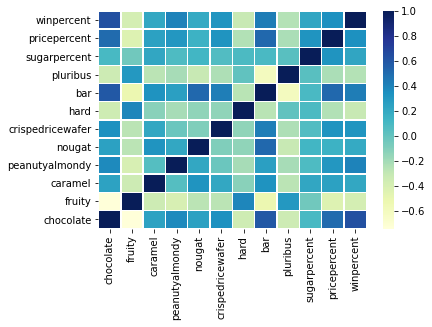

In [4]:
#Attribute correlation analysis
candyData = candyDataAll.drop(columns=['competitorname'])
corr = candyData.corr(method='pearson')
heatmap = sns.heatmap(corr, linewidth=0.5,cmap="YlGnBu").invert_yaxis()

### Inspect feature distribution

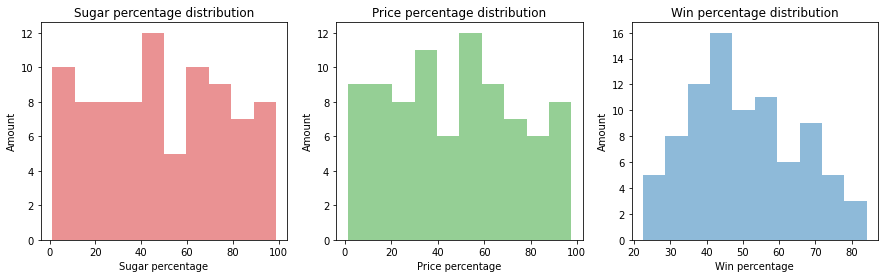

In [5]:
# Feature distribution
sugar = candyDataAll['sugarpercent']*100
price = candyDataAll['pricepercent']*100
win = candyDataAll['winpercent']
colors = ['tab:red', 'tab:green', 'tab:blue']
data = [sugar, price, win]
titles = ['Sugar percentage distribution','Price percentage distribution','Win percentage distribution']
labels = ['Sugar percentage','Price percentage','Win percentage']

fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)

for i in range(3):
    ax[i].hist(data[i], bins=10, color=colors[i], alpha = 0.5)
    ax[i].title.set_text(titles[i])
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel('Amount')

## Cluster Analysis
To analyze which features are most beneficial for high win percentage, we have to cluster the datapoints and analyze the features, that influence the average win percentage (further: awp) of each cluster

### Detect suitable cluster amount

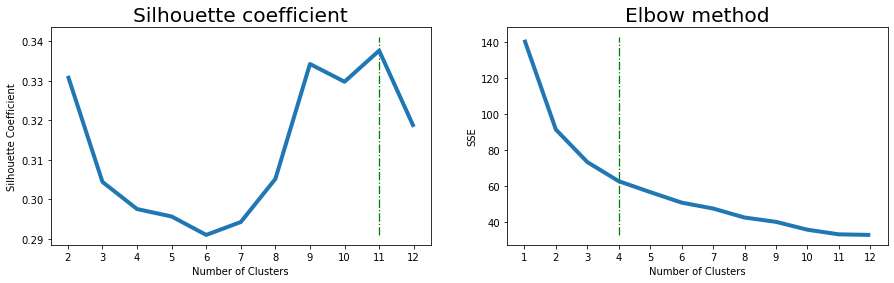

The optimal cluster amount based on silhouette coefficient method is  11
The optimal cluster amount based on elbow method is  4

Following, we will analyze both KMeans with  4  and with  11  clusters to decide which cluster has highes average winpercent with acceptable cluster size (ca. >10)


In [6]:
kmeans = KMeans(n_clusters = 2)
candyData = candyDataAll.drop(columns=['winpercent','competitorname'])

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

# to choose the appropriate number of clusters:
# silhouette coefficient = measure of cluster cohesion and separation
# values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters

silhouette_coefficients = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(candyData)
    score = silhouette_score(candyData, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
ax[0].set_title("Silhouette coefficient")
ax[0].plot(range(2, 13), silhouette_coefficients)
ax[0].set_xticks(range(2, 13))
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("Silhouette Coefficient")
ax[0].vlines(silhouette_coefficients.index(max(silhouette_coefficients))+2, ymin=min(silhouette_coefficients), ymax=1.01*max(silhouette_coefficients), colors='green', linestyles='dashdot', linewidth=1.3)


# to choose the appropriate number of clusters:
# elbow = measure of cluster cohesion and separation

sse = []
for k in range(1, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(candyData)
    sse.append(kmeans.inertia_)
ax[1].set_title("Elbow method")
ax[1].plot(range(1, 13), sse)
ax[1].set_xticks(range(1, 13))
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("SSE")
kl = KneeLocator(
    range(1, 13), sse, curve="convex", direction="decreasing")
ax[1].vlines(kl.elbow, ymin=min(sse), ymax=max(sse)*1.01, colors='green', linestyles='dashdot', linewidth=1.3)

plt.show()
print("The optimal cluster amount based on silhouette coefficient method is ", silhouette_coefficients.index(max(silhouette_coefficients))+2)
print("The optimal cluster amount based on elbow method is ", kl.elbow)
print()
print("Following, we will analyze both KMeans with ", kl.elbow, " and with ", silhouette_coefficients.index(max(silhouette_coefficients))+2, 
     " clusters to decide which cluster has highes average winpercent with acceptable cluster size (ca. >10)")



### Analyze clusters with KMeans

Since winpercentage is our target data, we exclude it from data which we cluster. Afterwards, we map the average winpercentage on resulted cluster and select the cluster with highest average winpercentage for further analysis of its features

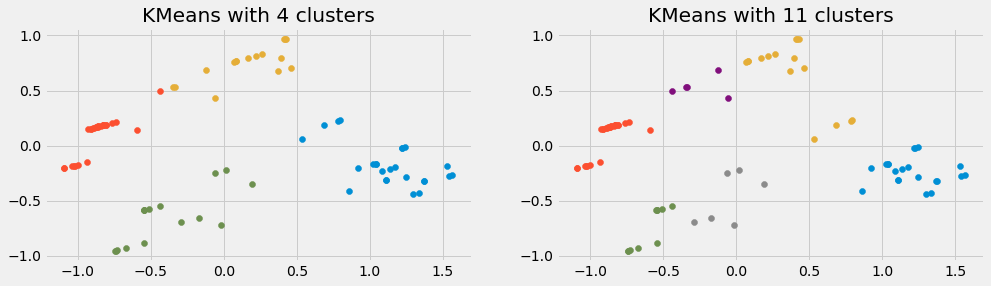

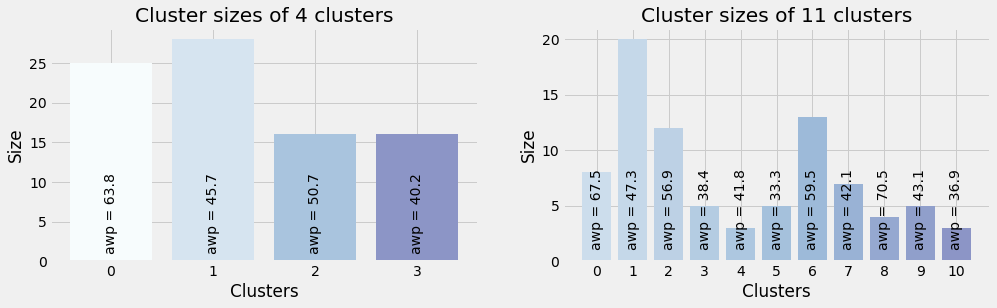

The largest of  4  clusters is: Cluster  1
The largest of  11  clusters is: Cluster  1


In [7]:
def autolabel(rects,axes, bar_plot):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        axes.text(rect.get_x() + rect.get_width()/2., 1,
                "awp = "+ str(winRates[idx]),
                ha='center', va='bottom', rotation=90)

pca = PCA(2)
cD = pca.fit_transform(candyData)

fig, ax = plt.subplots(1,2)
fig2,ax2 = plt.subplots(1,2)
fig.set_figwidth(15)
fig2.set_figwidth(15)


kmeansS = KMeans(n_clusters=silhouette_coefficients.index(max(silhouette_coefficients))+2)
label = kmeansS.fit_predict(cD)
u_labels = np.unique(label)
clusterSizes = []
winRates = []

# plot scatters for 11 clusters
for i in u_labels:
    ax[1].scatter(cD[label == i, 0], cD[label == i, 1], label = i)
    clusterSizes.append(cD[label == i,0].size)
    winPercentages = []
    for k in cD[label==i]:
        winPercentages.append(candyDataAll['winpercent'][np.where(cD==k)[0][0]])
    winRates.append(round(sum(winPercentages)/len(winPercentages),1))
ax[1].set_title("KMeans with " + str(silhouette_coefficients.index(max(silhouette_coefficients))+2) + " clusters"),

# plot barchart
colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(clusterSizes)))
#plt.set_facecolor('white')
bar_plt2 = ax2[1].bar(range(0,len(clusterSizes)),clusterSizes, color=colors, tick_label=range(0,len(clusterSizes)))
ax2[1].set_xlabel('Clusters')
ax2[1].set_ylabel('Size')
ax2[1].set_title('Cluster sizes of ' + str(len(clusterSizes)) + ' clusters')
maxClusterSIL = clusterSizes.index(max(clusterSizes))
autolabel(bar_plt2,ax2[1],bar_plt2)



kmeansE = KMeans(n_clusters=kl.elbow)
label = kmeansE.fit_predict(cD)
u_labels = np.unique(label)
clusterSizes = []
winRates = []

# plot scatters for 4 clusters
for i in u_labels:
    ax[0].scatter(cD[label == i, 0], cD[label == i, 1], label = i)
    clusterSizes.append(cD[label == i,0].size)
    winPercentages = []
    for k in cD[label==i]:
        winPercentages.append(candyDataAll['winpercent'][np.where(cD==k)[0][0]])
    winRates.append(round(sum(winPercentages)/len(winPercentages),1))
ax[0].set_title("KMeans with " + str(kl.elbow) + " clusters")

# plot barchart
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(clusterSizes)))
bar_plt = ax2[0].bar(range(0,len(clusterSizes)),clusterSizes, color=colors, tick_label=range(0,len(clusterSizes)))
ax2[0].set_xlabel('Clusters')
ax2[0].set_ylabel('Size')
ax2[0].set_title('Cluster sizes of ' + str(len(clusterSizes)) + ' clusters')
maxClusterEL = clusterSizes.index(max(clusterSizes))
autolabel(bar_plt,ax2[0],bar_plt)

plt.show()

print('The largest of ', kl.elbow, ' clusters is: Cluster ', maxClusterEL)
print('The largest of ', silhouette_coefficients.index(max(silhouette_coefficients))+2, ' clusters is: Cluster ', maxClusterSIL)


As we can see, the highest awp of 4 clusters is 63.8 with 25 datapoints; the highest awp of 11 clusters is 70.5 with 4 datapoints. Though the cluster with awp of 70.5 seems to be more beneficial, due to it containing only 4 datapoints, which is to little for a substantial analysis, we choose to analyze the features of the cluster wit awp=63.8 and 25 datapoints.

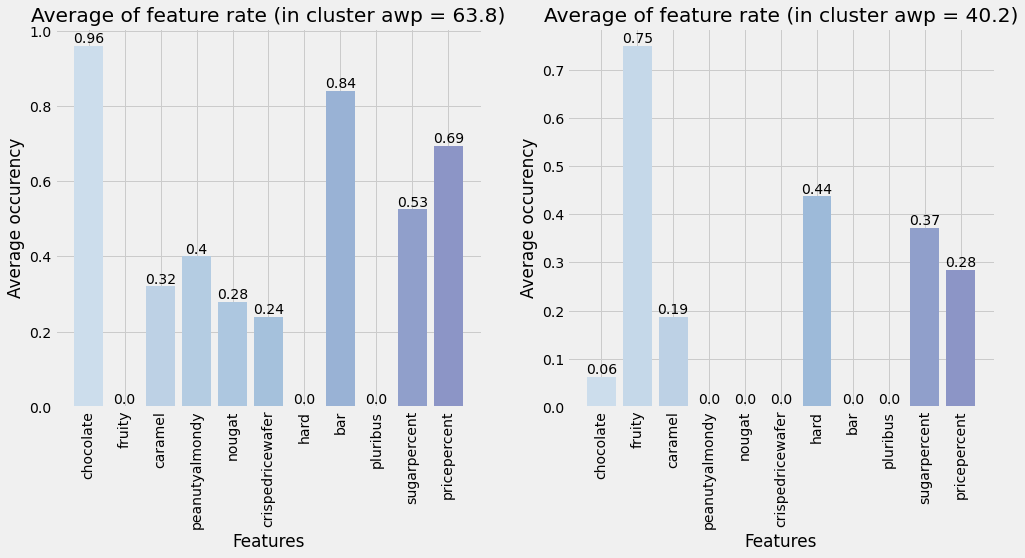

Blacklist: fruity, hard
Whitelist: fruity, hard


In [8]:
awpIdx = [winRates.index(max(winRates)), winRates.index(min(winRates))]
awpIdx_vals = [max(winRates), min(winRates)]
clusterCandies = [pd.DataFrame(columns=candyDataAll.columns), pd.DataFrame(columns=candyDataAll.columns)]

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(6.5)
for i in range(2):
    for k in cD[label==awpIdx[i]]:
        clusterCandies[i] = clusterCandies[i].append(candyDataAll.loc[np.where(cD==k)[0][0]])
    
    clusterCandies[i] = clusterCandies[i].drop(columns=['winpercent','competitorname'])
    vals = []
    for factor in clusterCandies[i].columns:
        vals.append(sum(clusterCandies[i][factor])/len(clusterCandies[i]))
        
        
        colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(vals)))
    bar_plt = ax[i].bar(range(0,len(vals)), vals, color=colors, tick_label=clusterCandies[i].columns)
    ax[i].set_xticklabels(clusterCandies[i].columns, rotation = 'vertical')
    ax[i].set_xlabel('Features')
    ax[i].set_ylabel('Average occurency')
    ax[i].set_title('Average of feature rate (in cluster awp = ' + str(awpIdx_vals[i]) + ')') 

    for idx,bar_plt in enumerate(bar_plt):
        height = bar_plt.get_height()
        ax[i].text(bar_plt.get_x() + bar_plt.get_width()/2., height,
                round(vals[idx],2),
                ha='center', va='bottom', rotation=0)
plt.show()
print("Blacklist: fruity, hard")
print("Whitelist: fruity, hard")

#### Blacklist: fruity, hard
#### Whitelist: choloate, bar, peanutalmondy, caramel, nogat, crispedricewafer

# Non-linear-regression
## Dataset preparation

In [9]:
#Quick Preprocessing to adjust win percentage formatting
candyDataProcessed = candyDataAll
candyDataProcessed['winpercent'] = candyDataProcessed['winpercent']/100
training_set, test_set = train_test_split(candyDataProcessed, test_size=0.2, random_state = 100)

#sugarpercent
X_train_s = training_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_train_s = training_set['sugarpercent']

X_test_s = test_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_test_s = test_set['sugarpercent']

#pricepercent
X_train_p = training_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_train_p = training_set['pricepercent']

X_test_p = test_set.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])
y_test_p = test_set['pricepercent']

#winpercent
X_train_w = training_set.drop(columns = ['competitorname', 'winpercent'])
y_train_w = training_set['winpercent']

X_test_w = test_set.drop(columns = ['competitorname', 'winpercent'])
y_test_w = test_set['winpercent']


## Random forest regressor vs K Neighbors regressor
### Create sugarpercent-predictor

In [10]:
def find_opt_neighbors(X_train, y_train, X_test, y_test):
    neighbor = 0
    res = 1
    for k in np.arange(5, 51, 5):
        knn_regressor = KNeighborsRegressor(n_neighbors = k,  p = 2, weights = 'uniform')
        knn_regressor.fit(X_train, y_train)
        y_pred = knn_regressor.predict(X_test)
        if mean_squared_error(y_pred,y_test, squared = False) < res:
            res = mean_squared_error(y_pred,y_test, squared = False);
            neighbor = k
    return neighbor

Random Forest Regressor:
MAE = 0.21720461571006067
MSE = 0.06871034940680228

KNN:
MAE = 0.16931528682352942
MSE = 0.047328772797732684


Text(0.5, 1.0, 'MSE')

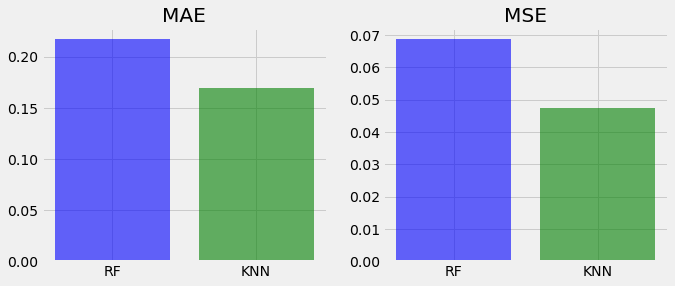

In [11]:
res = []
for k in np.arange(5, 51, 5):
    knn_regressor = KNeighborsRegressor(n_neighbors = k, 
                                    p = 2, 
                                    weights = 'uniform')
    knn_regressor.fit(X_train_s, y_train_s)
    y_pred = knn_regressor.predict(X_test_s)
    res.append([k,mean_squared_error(y_pred,y_test_s, squared = False)])

#Random Forest
clf_s=RandomForestRegressor(n_estimators=100)
clf_s.fit(X_train_s, y_train_s)
y_pred_s = clf_s.predict(X_test_s)
maeRF = mean_absolute_error(y_test_s,y_pred_s)
mseRF = mean_squared_error(y_test_s,y_pred_s)
print("Random Forest Regressor:")
print("MAE =", maeRF)
print("MSE =", mean_squared_error(y_test_s,y_pred_s))

# K Nearest Neighbors
print("\nKNN:")
knn_regressor_s = KNeighborsRegressor(n_neighbors = find_opt_neighbors(X_train_s, y_train_s, X_test_s, y_test_s),
                                      p = 2, weights = 'uniform')
knn_regressor_s.fit(X_train_s, y_train_s)
y_pred_s_knn = knn_regressor_s.predict(X_test_s)
maeKNN = mean_absolute_error(y_test_s,y_pred_s_knn)
mseKNN = mean_squared_error(y_test_s,y_pred_s_knn)
print("MAE =", maeKNN)
print("MSE =", mean_squared_error(y_test_s,y_pred_s_knn))

#Plot
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].bar('RF', maeRF, color = 'blue', alpha = 0.6)
ax[0].bar('KNN', maeKNN, color = 'green', alpha = 0.6)
ax[0].set_title('MAE')
ax[1].bar('RF', mseRF, color = 'blue', alpha = 0.6)
ax[1].bar('KNN', mseKNN, color = 'green', alpha = 0.6)
ax[1].set_title('MSE')

### Create pricepercent-predictor

Random Forest Regressor:
MAE = 0.18420295328552205
MSE = 0.0456908420851074

KNN:
MAE = 0.1706823507058824
MSE = 0.04297164665854133


Text(0.5, 1.0, 'MSE')

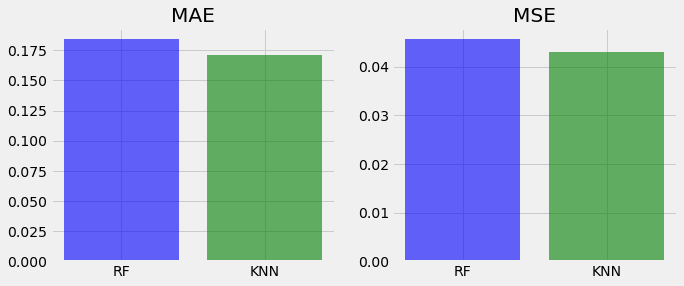

In [12]:
#Random Forest
clf_p=RandomForestRegressor(n_estimators=100)
clf_p.fit(X_train_p, y_train_p)
y_pred_p = clf_p.predict(X_test_p)
maeRF = mean_absolute_error(y_test_p,y_pred_p)
mseRF = mean_squared_error(y_test_p,y_pred_p)
print("Random Forest Regressor:")
print("MAE =", maeRF)
print("MSE =", mseRF)

#K Nearest Neighbors
print("\nKNN:")
knn_regressor_p = KNeighborsRegressor(n_neighbors = find_opt_neighbors(X_train_p, y_train_p, X_test_p, y_test_p), 
                                      p = 2, weights = 'uniform')
knn_regressor_p.fit(X_train_p, y_train_p)
y_pred_p_knn = knn_regressor_p.predict(X_test_p)
maeKNN = mean_absolute_error(y_test_p,y_pred_p_knn)
mseKNN = mean_squared_error(y_test_p,y_pred_p_knn)
print("MAE =", maeKNN)
print("MSE =", mseKNN)

#Plot
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].bar('RF', maeRF, color = 'blue', alpha = 0.6)
ax[0].bar('KNN', maeKNN, color = 'green', alpha = 0.6)
ax[0].set_title('MAE')
ax[1].bar('RF', mseRF, color = 'blue', alpha = 0.6)
ax[1].bar('KNN', mseKNN, color = 'green', alpha = 0.6)
ax[1].set_title('MSE')

### Create winpercent-predictor

Random Forest Regressor:
MAE = 0.09597995840176496
MSE = 0.015647639892574478

KNN:
MAE = 0.09626410952941178
MSE = 0.013005556901130064


Text(0.5, 1.0, 'MSE')

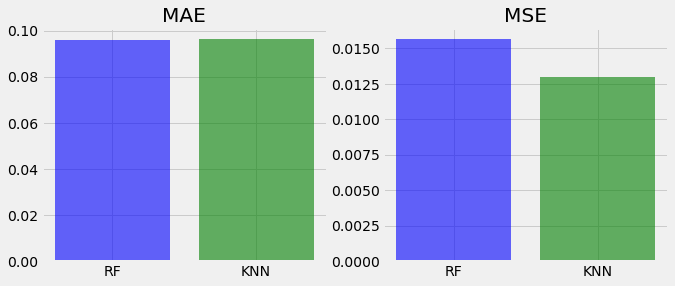

In [13]:
#Random Forest
clf_w=RandomForestRegressor(n_estimators=100)
clf_w.fit(X_train_w, y_train_w)
y_pred_w = clf_w.predict(X_test_w)
maeRF = mean_absolute_error(y_test_w,y_pred_w)
mseRF = mean_squared_error(y_test_w,y_pred_w)
print("Random Forest Regressor:")
print("MAE =", maeRF)
print("MSE =", mseRF)

#K Nearest Neighbors
print("\nKNN:")
knn_regressor_w = KNeighborsRegressor(n_neighbors = 5, p = 2, weights = 'uniform')
knn_regressor_w.fit(X_train_w, y_train_w)
y_pred_w_knn = knn_regressor_w.predict(X_test_w)
maeKNN = mean_absolute_error(y_test_w,y_pred_w_knn)
mseKNN = mean_squared_error(y_test_w,y_pred_w_knn)
print("MAE =", maeKNN)
print("MSE =", mseKNN)

#Plot
fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
ax[0].bar('RF', maeRF, color = 'blue', alpha = 0.6)
ax[0].bar('KNN', maeKNN, color = 'green', alpha = 0.6)
ax[0].set_title('MAE')
ax[1].bar('RF', mseRF, color = 'blue', alpha = 0.6)
ax[1].bar('KNN', mseKNN, color = 'green', alpha = 0.6)
ax[1].set_title('MSE')

### Feature importance

Text(0.5, 1.0, 'Feature importance')

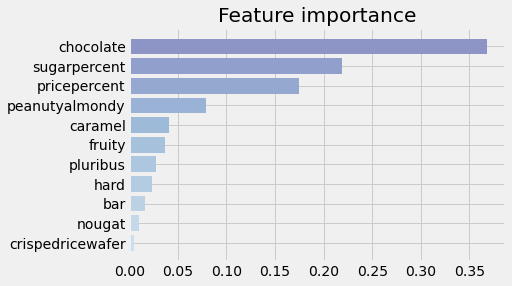

In [14]:
f_imp = []
for i in range(0,len(clf_w.feature_importances_)):
    f_imp.append([X_train_w.columns[i], clf_w.feature_importances_[i]])
f_imp = sorted(f_imp, key=itemgetter(1), reverse=False)
columns = [f_i[0] for f_i in f_imp]
values = [f_i[1] for f_i in f_imp]

colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(X_train_w.columns)))
plt.barh(columns, values, color=colors)
plt.title("Feature importance")

<BarContainer object of 9 artists>

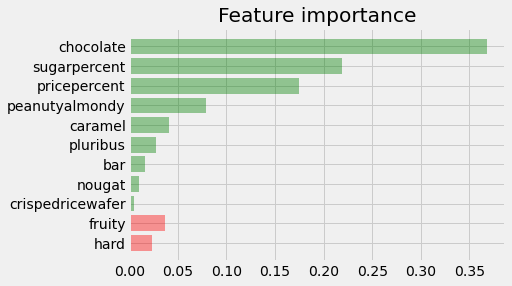

In [29]:
stoplist = ['hard', 'fruity']
red = []
green = []
for i in range(0,len(f_imp)):
    if f_imp[i][0] in stoplist:
        red.append(f_imp[i])
    else:
        green.append(f_imp[i])
        
columns = [f_i[0] for f_i in red]
values = [f_i[1] for f_i in red]
plt.barh(columns, values,  color='red', alpha = 0.4)
plt.title("Feature importance")


columns = [f_i[0] for f_i in green]
values = [f_i[1] for f_i in green]
plt.barh(columns, values, color='green', alpha=0.4)



## Predict New Candy
### Create Methods

In [16]:
# dataline should have the format of a Dataframe!

def predSugar_KNN(dataline):
    return knn_regressor_s.predict(dataline)

def predPrice_KNN(dataline):
    return knn_regressor_p.predict(dataline)

def predWin_KNN(dataline):
    sugar = predSugar_KNN(dataline)
    price = predPrice_KNN(dataline)
    dataline['sugarpercent'] = sugar
    dataline['pricepercent'] = price
    return knn_regressor_w.predict(dataline)

def predWin_All_KNN(dataline):
    return knn_regressor_w.predict(dataline)

### Predict

In [17]:
dataline = pd.DataFrame(columns= candyDataAll.columns)
dataline = dataline.drop(columns = ['competitorname', 'sugarpercent', 'pricepercent', 'winpercent'])

In [18]:
badCandy = {'chocolate':0, 'fruity':1, 'caramel':0, 'peanutyalmondy':0, 'nougat':0, 'crispedricewafer':0, 'hard':1, 'bar':0, 'pluribus':0}
goodCandy = {'chocolate':1, 'fruity':0, 'caramel':1, 'peanutyalmondy':1, 'nougat':1, 'crispedricewafer':1, 'hard':0, 'bar':1, 'pluribus':0}

dataline = dataline.append(badCandy, ignore_index=True)
dataline = dataline.append(goodCandy, ignore_index=True)
pred_win = predWin_KNN(dataline)

dataline['winpercent'] = pred_win

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,0,1,0,0,0,0,1,0,0,0.46688,0.3088,0.384180
1,1,0,1,1,1,1,0,1,0,0.55712,0.7670,0.676316


### Evaluate

<BarContainer object of 2 artists>

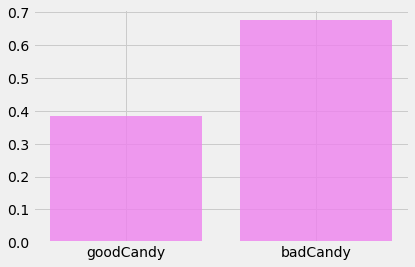

In [19]:
dataline
plt.bar(['goodCandy','badCandy'],dataline['winpercent'], color='violet', alpha=0.8)

# Conclusions
After exploring, analyzing and computing on the base of the "halloween candy ranking" dataset following results and findings were gathered:

1. While producing a new candy one should primarily consider the features choloate, bar and peanutyalmondy. Furthermore, the attributes caramel, nougat, pluribus and crispedricewafer. Contrary attributes like fruity and hard should be avoided.

3. For the optimization and consultation on the creation of new candy products, a machine learning model was created. It predicts the sugarpercent, pricepercent and the winpercent of a given candy.
